In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyRegressor, DummyClassifier

import xgboost

import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from statsmodels.formula.api import ols
import statsmodels.api as sm

from statsmodels.stats.multicomp import pairwise_tukeyhsd


%matplotlib inline


In [2]:
df_training = pd.read_csv('./data/training_set_values.csv')

In [3]:
df_test = pd.read_csv('./data/test_set_values.csv')

In [4]:
df_training_labels = pd.read_csv('./data/training_set_labels.csv')

In [5]:
df_training.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
df_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [7]:
df_training_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
df_training.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [9]:
df_test.isna().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                    869
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7092
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

In [10]:
df_merge = pd.merge(df_training_labels, df_training, how='inner', on='id')


In [11]:
df_merge.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [12]:
df_merge['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [13]:
df_merge['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [14]:
type(df_merge)

pandas.core.frame.DataFrame

In [15]:
df_merge.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

In [16]:
len(df_merge['scheme_management'].unique())

13

In [17]:
len(df_merge['scheme_name'].unique())

2697

In [18]:
df_merge.funder.value_counts()

Government Of Tanzania         9084
Danida                         3114
Hesawa                         2202
Rwssp                          1374
World Bank                     1349
                               ... 
Lake Tanganyika Basin             1
Tanz/egypt Technical  Co-op       1
Ldcgd                             1
Misri Government                  1
Mhoranzi                          1
Name: funder, Length: 1897, dtype: int64

In [19]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [20]:
df_merge.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [21]:
df_merge['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [22]:
df_merge['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [23]:
df_merge['district_code'].value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [24]:
df_merge['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [25]:
df_merge['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [26]:
df_merge['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [27]:
df_merge['wpt_name'].value_counts()

none                       3563
Shuleni                    1748
Zahanati                    830
Msikitini                   535
Kanisani                    323
                           ... 
Ester Wandwi                  1
Mbamai                        1
Kabitega                      1
Mazashai Primary School       1
Kwa Mwl Muhako                1
Name: wpt_name, Length: 37400, dtype: int64

In [28]:
df_merge['installer'].value_counts()

DWE               17402
Government         1825
RWE                1206
Commu              1060
DANIDA             1050
                  ...  
KAGERA MINE           1
TASAF 1               1
DIMON                 1
Males                 1
Jackson Makore        1
Name: installer, Length: 2145, dtype: int64

In [29]:
df_merge = df_merge.drop(['id',
                          'date_recorded', 
                          'num_private',
                          'subvillage',
                          'recorded_by', 
                          'scheme_name',
                          'waterpoint_type_group',
                          'source_type',
                          'quantity_group',
                          'quality_group',
                          'latitude',
                          'longitude',
                          'payment',
                          'management_group',
                          'district_code',
                          'region_code',
                          'wpt_name',
                          'funder',
                          'installer',
                          'public_meeting',
                          'scheme_management',
                          'permit',
                          'construction_year'
                         ], axis = 1)

In [30]:
df_merge.isna().sum()

status_group             0
amount_tsh               0
gps_height               0
basin                    0
region                   0
lga                      0
ward                     0
population               0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
payment_type             0
water_quality            0
quantity                 0
source                   0
source_class             0
waterpoint_type          0
dtype: int64

In [31]:
df_merge['status_class'] = df_merge.status_group.map({"non functional":0, "functional needs repair":1, "functional":2})
df_merge

,status_group,amount_tsh,gps_height,basin,region,lga,ward,population,extraction_type,extraction_type_group,extraction_type_class,management,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_class
0,functional,6000.0,1390,Lake Nyasa,Iringa,Ludewa,Mundindi,109,gravity,gravity,gravity,vwc,annually,soft,enough,spring,groundwater,communal standpipe,2
1,functional,0.0,1399,Lake Victoria,Mara,Serengeti,Natta,280,gravity,gravity,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,2
2,functional,25.0,686,Pangani,Manyara,Simanjiro,Ngorika,250,gravity,gravity,gravity,vwc,per bucket,soft,enough,dam,surface,communal standpipe multiple,2
3,non functional,0.0,263,Ruvuma / Southern Coast,Mtwara,Nanyumbu,Nanyumbu,58,submersible,submersible,submersible,vwc,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,0
4,functional,0.0,0,Lake Victoria,Kagera,Karagwe,Nyakasimbi,0,gravity,gravity,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,functional,10.0,1210,Pangani,Kilimanjaro,Hai,Masama Magharibi,125,gravity,gravity,gravity,water board,per bucket,soft,enough,spring,groundwater,communal standpipe,2
59396,functional,4700.0,1212,Rufiji,Iringa,Njombe,Ikondo,56,gravity,gravity,gravity,vwc,annually,soft,enough,river,surface,communal standpipe,2
59397,functional,0.0,0,Rufiji,Mbeya,Mbarali,Chimala,0,swn 80,swn 80,handpump,vwc,monthly,fluoride,enough,machine dbh,groundwater,hand pump,2
59398,functional,0.0,0,Rufiji,Dodoma,Chamwino,Mvumi Makulu,0,nira/tanira,nira/tanira,handpump,vwc,never pay,soft,insufficient,shallow well,groundwater,hand pump,2


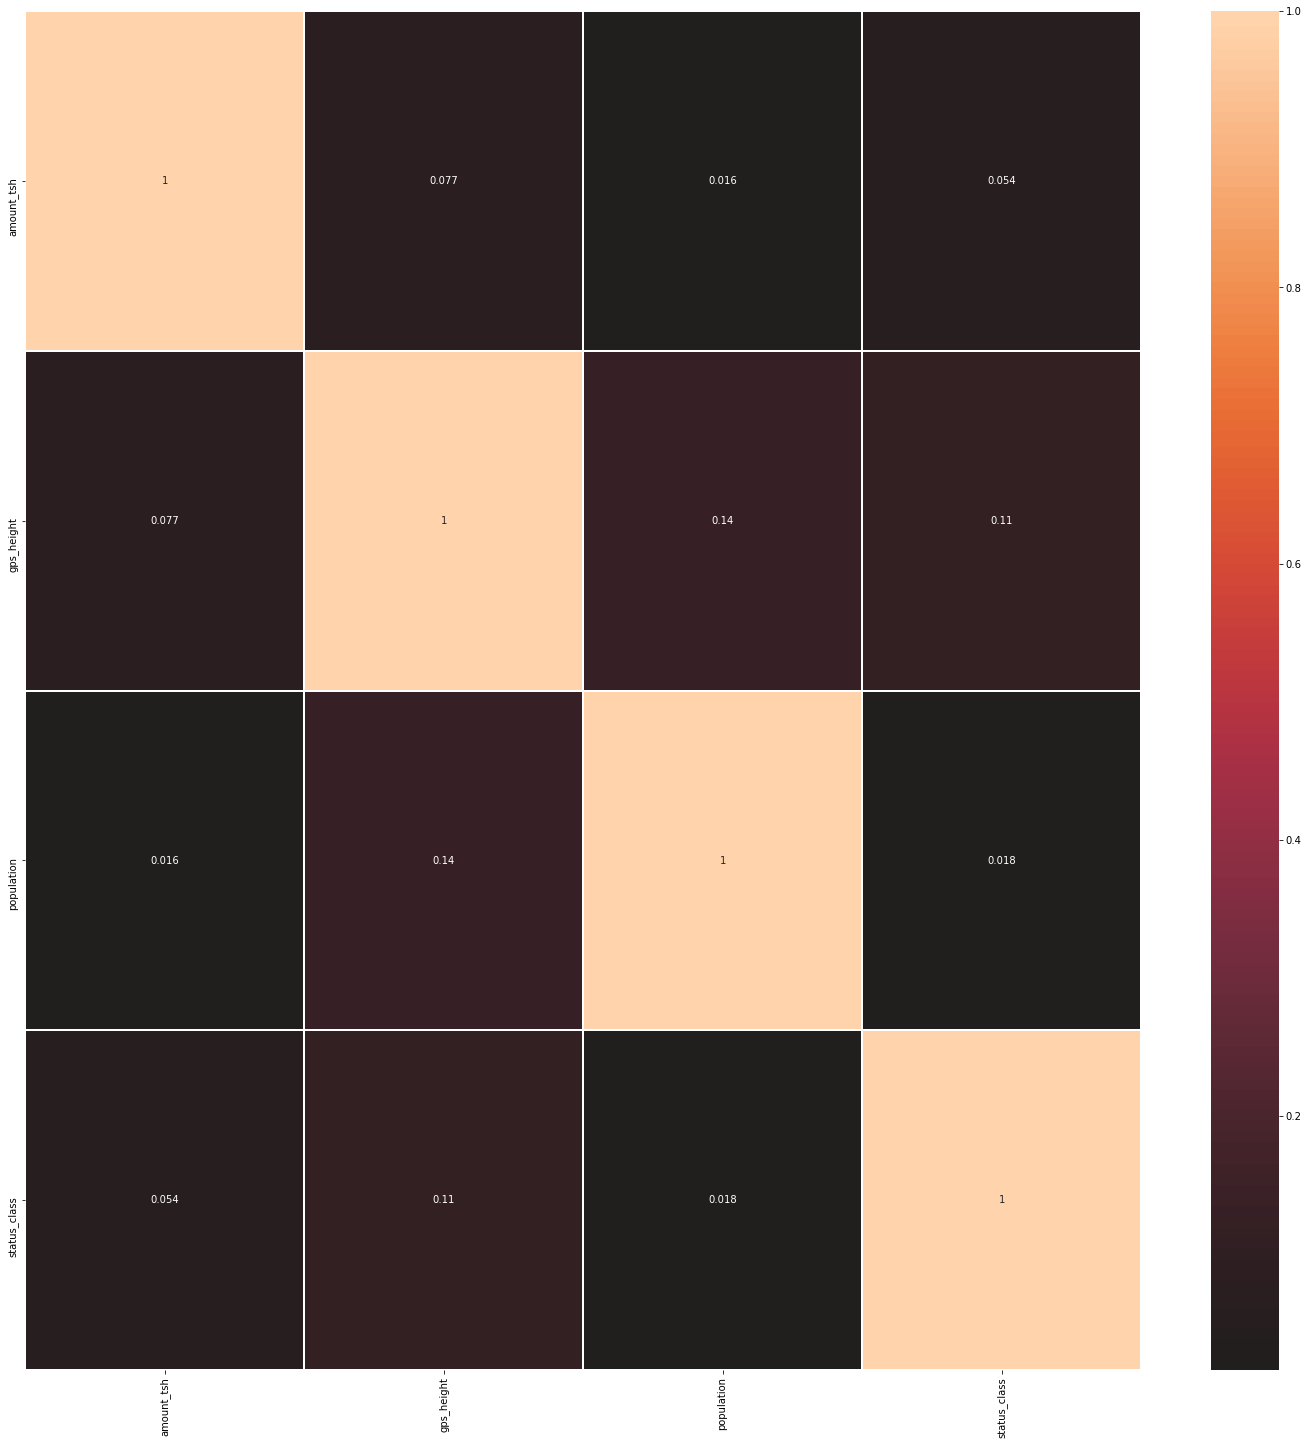

In [32]:
# Use pearson method for correlation mean
correlation_mean = df_merge.corr(method = 'pearson')

# Create correlation matrix
fig, ax = plt.subplots(figsize=(25,25)) 
ax = sns.heatmap(correlation_mean, center=0, linewidths=1, annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_xticklabels())
plt.show()

In [33]:
X = df_merge.drop(['status_group','status_class'], axis=1)
y= df_merge['status_class']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

In [36]:
def grab_object(df):
    return df.select_dtypes(include=['object'])

In [37]:
# The FunctionTransformer will turn my function into a transformer.

GrabNumeric = FunctionTransformer(grab_numeric)

In [38]:
GrabObject = FunctionTransformer(grab_object)

In [39]:
GrabNumeric.fit(X_train)

FunctionTransformer(func=<function grab_numeric at 0x000001E5E539A160>)

In [40]:
# Create first pipeline

pipe = Pipeline(steps=[
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])

In [41]:
subpipe_num = Pipeline(steps=[('get_num', GrabNumeric),
                              ('num_impute', SimpleImputer()),
                              ('ss', StandardScaler())])


subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])


In [42]:
ct = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, [0,1,6]),
    ('subpipe_cat', subpipe_cat, [2,3,4,5,7,8,9,10,11,12,13,14,15,16])])

In [43]:
#Checking to see if columns have been transformed and also checking to see how many total columns
pd.DataFrame(ct.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,2312,2313,2314,2315,2316,2317,2318,2319,2320,2321
0,-0.084999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.100621,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.100621,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.100621,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.006889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47515,0.211821,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47516,0.211821,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47517,-0.100621,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
47518,-0.100621,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [44]:
# Creating a dummy model pipeline & fitting it to X and y train

dummy_mod_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy_model', DummyClassifier(strategy='most_frequent'))
    ])

dummy_mod_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x000001E5E539A160>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 1, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                 

In [45]:
dummy_mod_pipe.score(X_train, y_train)

0.5429713804713805

In [46]:
logreg_model_pipe = Pipeline(steps=[
    ('ct',ct),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

In [47]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x000001E5E539A160>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 1, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                 

In [48]:
logreg_model_pipe.score(X_train, y_train)

0.7867213804713805

In [50]:
random_forest_class = RandomForestClassifier(random_state=42)

random_forest_model_pipe = Pipeline([('ct', ct), ('rfc', random_forest_class)])

In [51]:
random_forest_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x000001E5E539A160>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 1, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                 

In [52]:
random_forest_model_pipe.score(X_train, y_train)

0.8892676767676768

In [53]:
xgboost = xgboost.XGBClassifier(random_state=42, objective='binary:logistic')

xgboost_pipeline = Pipeline([('ct', ct), ('xgboost', xgboost)])

In [54]:
xgboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x000001E5E539A160>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 1, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                 

In [55]:
xgboost_pipeline.score(X_train, y_train)

0.7916245791245792

# Run grid_search 

### Create paramaters for grid_search

In [56]:
# params = {}

# params['rfc__criterion'] = ['gini','entropy']
# params['rfc__min_samples_leaf'] = [1,5,10]

In [57]:
# grid_search = GridSearchCV(estimator=random_forest_model_pipe, param_grid=params, cv=5)

In [58]:
# grid_search.fit(X_train,y_train)

In [59]:
# grid_search.best_estimator_

In [60]:
# grid_search.best_params_

In [61]:
# grid_search.score(X_train, y_train)

In [62]:
# grid_search.score(X_test, y_test)

In [63]:
# final_model = grid_search.best_estimator_

In [64]:
# plot_confusion_matrix(final_model, X_test, y_test);

In [65]:
final_random_forest_class = RandomForestClassifier(criterion = 'gini' , min_samples_leaf = 1,random_state=42)

final_random_forest_model_pipe = Pipeline([('ct', ct), ('rfc', final_random_forest_class)])

In [66]:
final_random_forest_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x000001E5E539A160>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 1, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                 

In [67]:
final_random_forest_model_pipe.score(X_train, y_train)

0.8892676767676768

In [68]:
final_random_forest_model_pipe.score(X_test, y_test)

0.7929292929292929

In [69]:
broken_well_graph = df_merge.copy()

In [70]:
brk_well_graph_xaxis = broken_well_graph['status_class']

In [71]:
brk_well_yaxis = len(broken_well_graph['status_class'])

In [72]:
len(broken_well_graph['status_group'])

59400

In [73]:
broken_well_graph['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [74]:
len(broken_well_graph)

59400

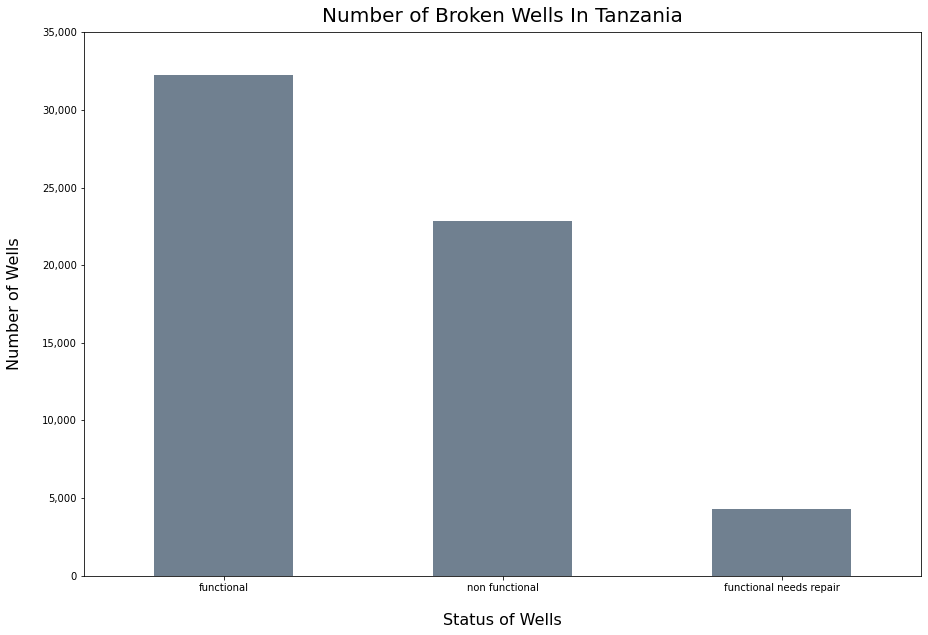

In [76]:
fig, ax = plt.subplots(figsize = (15, 10))


ax = broken_well_graph['status_group'].value_counts().plot(kind='bar', color='slategrey');
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_title('Number of Broken Wells In Tanzania', fontsize='20', pad=10)
ax.set_xlabel('Status of Wells', fontsize='16', labelpad=20)
ax.set_ylabel('Number of Wells', fontsize='16', labelpad=20)
ax.set_ylim([0, 35000])

plt.xticks(rotation=0)


plt.savefig('./images/Num_Broken_Wells_Bar_Chart', bbox_inches="tight", dpi=500);